In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import scipy.special as special
import scipy.stats as spstats

# Primer on 2-D Gaussian Distributions

We start with the full 2-dimensional Gaussian PDF (lifted from wikipedia):

$$f(x,y) = \frac{1}{2 \pi \sigma_X \sigma_Y \sqrt{1-\rho^2}} e^{-\frac{1}{2(1-\rho^2)} \left[ (\frac{x - \mu_X}{\sigma_X})^2 + \frac{y - \mu_Y}{\sigma_Y})^2 - 2 \rho (\frac{x - \mu_X}{\sigma_X}) (\frac{y - \mu_Y}{\sigma_Y}) \right]}$$

For our purposes, we're only really concerned with ellipses, and the orientation of the ellipse doesn't particularly matter for now, so let's set $\rho = 0$ and define $\sigma_Y = 1$, while we adjust the means $\mu_X, \mu_Y$ later accordingly. We then get the much simpler:

$$f(x,y) = \frac{1}{2 \pi \sigma_X} e^{-\frac{1}{2} \left[ (\frac{x - \mu_X}{\sigma_X})^2 + \frac{y - \mu_Y}{1})^2 \right] }$$

We now just need to adjust $\sigma_X$ to be our relative stretch of the ellipse.

Let's start with the zero-mean example of a circular distribution i.e. $\sigma_X = 1, \mu_X = \mu_Y = 0$:

$$f(x,y) = \frac{1}{2 \pi} e^{-\frac{1}{2} \left[ x^2 + y^2 \right]} $$

There's no indefinite integral for Gaussians, so we can only use the error function given by

$$ erf(x) = \frac{2}{\sqrt{\pi}} \int_0^x e^{-t^2} dt $$

which is the probability of obtaining a random variable in the range $[-x,x]$ for a zero-mean standard deviation of (**IMPORTANT**) $\frac{1}{\sqrt{2}}$. Explicitly, we convert the distribution via

$$\begin{align}
f(x,y) &= \frac{1}{2 \pi} e^{-\frac{1}{2} \left[ x^2 + y^2 \right]} \\
&= \frac{1}{\sqrt{2\pi}} e^{-\frac{1}{2} x^2} \frac{1}{\sqrt{2\pi}} e^{-\frac{1}{2} y^2} \\
\end{align}
$$

The two terms are independent and can be integrated separately (and are identical anyway) so we just integrate over the desired limits $-a, a$ by defining our dummy variable $t = \frac{x}{\sqrt{2}}, dx = \sqrt{2} dt$ like so:

$$\begin{align}
\frac{1}{\sqrt{2\pi}} \int_{-a}^{a}  e^{-\frac{1}{2} x^2} &= \frac{2}{\sqrt{2 \pi}} \int_{0}^{a} e^{-\frac{1}{2} x^2} dx\\
&= \frac{2}{\sqrt{\pi}} \int_{0}^{a/\sqrt{2}} e^{-t^2} dt\\
&= erf\left(a/\sqrt{2}\right)
\end{align}
$$

This form results in the standard 68, 95, 99.7 rule as demonstrated here:

In [2]:
print(special.erf(1/np.sqrt(2)))
print(special.erf(2/np.sqrt(2)))
print(special.erf(3/np.sqrt(2)))

0.6826894921370859
0.9544997361036416
0.9973002039367398


But more importantly, for 2-D and above the product of the two $erf$ functions must be taken into account, which results in the equivalent of the $1,2,3 \sigma$ rule becoming:

In [3]:
print(special.erf(1/np.sqrt(2))**2)
print(special.erf(2/np.sqrt(2))**2)
print(special.erf(3/np.sqrt(2))**2)

0.4660649426743922
0.9110697462219214
0.9946076967722628


But wait! What we did here is an integral over a **SQUARE** with limits $[-a,a], [-a,a]$. What we're most likely concerned with is a smooth circular integral that stretches $c = 1 \sigma$ in all directions (in the circular case), as this would *respect* the evolution of the probability distribution. To do this we simply integrate using the conditional limits by defining the **POLAR** limits and integrating via polar coordinates like so, $r^2 = x^2 + y^2$:

$$ \begin{align}
\frac{1}{2\pi} \int_{0}^{2\pi} \int_{0}^{c} e^{-\frac{1}{2} r^2} r dr d\theta &= \frac{1}{2\pi}  \int_{0}^{2\pi} \left[ \int_{0}^{c} r e^{-\frac{1}{2} r^2}  dr \right] d\theta \\
&= \frac{1}{2\pi}  \int_{0}^{2\pi} \left[ \left(1 -e^{ -\frac{1}{2} c^2} \right) \right] d\theta \\
&= 1 -e^{ -\frac{1}{2} c^2}
\end{align}
$$

The equivalent of the $1,2,3 \sigma$ rule is then:

In [4]:
def circularProbability(c):
    return (1-np.exp(-0.5*c**2))

print(circularProbability(1))
print(circularProbability(2))
print(circularProbability(3))

0.3934693402873666
0.8646647167633873
0.9888910034617577


We can verify this via simulation, counting everything within multiple sigmas..

0.39199
0.86558
0.98945


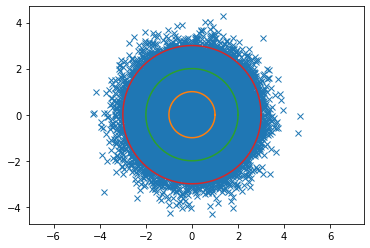

In [5]:
mean = [0, 0]
cov = [[1, 0], [0, 1]]  # diagonal covariance

x, y = np.random.multivariate_normal(mean, cov, 100000).T

theta = np.arange(0,2*np.pi+0.001/2,0.001)
circx = np.cos(theta)
circy = np.sin(theta)

plt.figure()
plt.plot(x, y, 'x')
plt.plot(circx,circy)
plt.plot(2*circx,2*circy)
plt.plot(3*circx,3*circy)
plt.axis('equal')

xy = np.vstack((x,y)).T
xynorm = np.linalg.norm(xy, axis=1)
print(len(np.argwhere(xynorm <= 1)) / len(xynorm))
print(len(np.argwhere(xynorm <= 2)) / len(xynorm))
print(len(np.argwhere(xynorm <= 3)) / len(xynorm))

The most straightforward way to extend from circular to elliptical distributions and see that the same rules hold - that is, that drawing an ellipse which matches the $n \sigma$ on both the major and minor axes will also result in the same percentages - is to simply construct a linear transform matrix which shapes the ellipse back to the circle. It shouldn't be too hard to see heuristically that the linear transforms preserve the percentages, but explicitly, we may consider the general 2-D Gaussian distribution (un-correlated i.e. $\rho = 0$):

$$
f(x,y) = \frac{1}{2 \pi \sigma_X \sigma_Y} e^{-\frac{1}{2} \left[ (\frac{x - \mu_X}{\sigma_X})^2 + \frac{y - \mu_Y}{\sigma_Y})^2 \right] }
$$

Correlated distributions (i.e. ellipses not aligned to the x-axis or y-axis) may be simply rotated in the plane to this form, so we will focus on this. Then, for arbitrary $\sigma_X, \sigma_Y$, we may use these to appropriately parametrize $x, y$ in the following manner:

$$
x = \sigma_X r \cos \theta \\
y = \sigma_Y r \sin \theta
$$

Integrating the distribution over the ellipse for $1 \sigma$ in both directions appropriately results in the Jacobian 

$$
\sigma_X \sigma_Y r dr d\theta
$$

instead of the unit-circle case of 

$$
r dr d\theta
$$

It is clear that the integrand when compared to the unit-circle case has now transformed like so:

$$
\frac{1}{2 \pi} e^{-\frac{1}{2} \left[x^2 + y^2 \right]} (r) = \frac{1}{2 \pi} e^{-\frac{1}{2} r^2} (r) \rightarrow \frac{1}{2 \pi \sigma_X \sigma_Y} e^{-\frac{1}{2} r^2} (\sigma_X \sigma_Y r) = \frac{1}{2 \pi \sigma_X \sigma_Y} e^{-\frac{1}{2} \left[ (\frac{x - \mu_X}{\sigma_X})^2 + \frac{y - \mu_Y}{\sigma_Y})^2 \right]} (\sigma_X \sigma_Y r)
$$

The limits have not changed, since we edited the Jacobian to account for our transformation of the differential area; hence since the extra coefficients of $\sigma_X \sigma_Y$ cancel out the $\frac{1}{\sigma_X \sigma_Y}$ of the denominator, we are left with the original integral

$$
\text{Integral over 1 sigma of ellipse} = \frac{1}{2 \pi \sigma_X \sigma_Y} \int_0^{2\pi} \int_0^1  e^{-\frac{1}{2} r^2} (\sigma_X \sigma_Y r) dr d\theta = \frac{1}{2 \pi} \int_0^{2\pi} \int_0^1 e^{-\frac{1}{2} r^2} r dr d\theta = \text{Integral over 1 sigma of unit circle}
$$

As usual, we can easily verify this via simulations:

0.39342
0.86525
0.98908


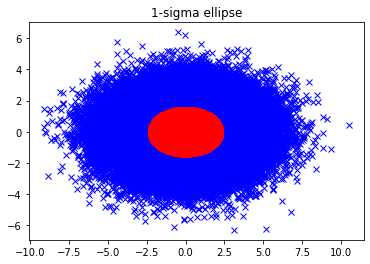

In [6]:
# Assumes each x,y pair in each row
def pointsInUncorrelatedZeroMeanEllipse(points, axx, axy):
    norms = np.linalg.norm(points, axis=1) # find the norm for each point from origin

    theta = np.arctan2(points[:,1]*axx, points[:,0]*axy) # find the equivalent theta for the ellipse projection for each point
    ellipseX = axx * np.cos(theta) # find the ellipse projection for each point with the same angle
    ellipseY = axy * np.sin(theta)
    ellipse = np.vstack((ellipseX, ellipseY)).T
    ellipseNorms = np.linalg.norm(ellipse, axis=1)
    
    isInEllipseIdx = np.argwhere(norms < ellipseNorms)
    
    return ellipse, isInEllipseIdx

mean = [0, 0]
cov = [[5, 0], [0, 2]]  # diagonal covariance

x, y = np.random.multivariate_normal(mean, cov, 100000).T
points = np.vstack((x,y)).T

# find the number of points in 1 sigma
ellipse, isInEllipseIdx = pointsInUncorrelatedZeroMeanEllipse(points, np.sqrt(cov[0][0]), np.sqrt(cov[1][1])) 

plt.figure()
plt.plot(x[:], y[:], 'bx')
plt.plot(ellipse[:,0], ellipse[:,1], 'k.')
plt.plot(points[isInEllipseIdx,0], points[isInEllipseIdx,1], 'ro')
plt.axis('equal')
plt.title("1-sigma ellipse")

print(len(isInEllipseIdx) / len(points))

# find the number of points in 2 or 3 sigma
ellipse, isInEllipseIdx = pointsInUncorrelatedZeroMeanEllipse(points, 2*np.sqrt(cov[0][0]), 2*np.sqrt(cov[1][1])) 
print(len(isInEllipseIdx) / len(points))
ellipse, isInEllipseIdx = pointsInUncorrelatedZeroMeanEllipse(points, 3*np.sqrt(cov[0][0]), 3*np.sqrt(cov[1][1])) 
print(len(isInEllipseIdx) / len(points))

# Combining Elliptical Errors (for Localization)

You have $N$ localization measurements with index $i=0,1,...,N-1$: each has its own error ellipse (i.e. covariance matrix $\Sigma_i$) and measurement mean $\mu_i$ which denotes the point. The error ellipses may not be equal nor aligned i.e. they can be rotated in any 'direction' and their semi-major/minor axes may all be different. This would reflect the typical scenario where there are different measurements (perhaps from different times, different sensors or any combination thereof) which have different *uncertainties*, of which the individual i'th measurement's uncertainty has been **estimated** and thence assigned to the values of the covariance matrix (the fact that it is estimated will become important soon).

The problem is usually this: find the best average of all the measurements, along with an 'averaged' ellipse to reflect the *standard error of the mean*. The former is usually straightforward, so we start with that.

## Precision-weighted mean

With differing measurement uncertainties, the only respectable way to combine the measurements would be to weight them via their precision; that is, the weighted average is given by

$$
\bar{\mu} = \frac{\sum_{i=0}^{N-1} \Sigma_i^{-1} \mu_i} {\sum_{i=0}^{N-1} \Sigma_i^{-1}}
$$

This is also known as the *inverse-variance weighted mean/average*. Each measurement is weighted by the inverse variance, favouring the *certain* measurements over the *uncertain* measurements. In the case that all the variances are equal this reverts to the simple mean

$$
\bar{\mu} = \frac{\sum_{i=0}^{N-1} \mu_i} {N}
$$

Nothing to dispute here, and no confusion; what is usually the issue is defining the final combined ellipse or what the standard error of this mean should be.

## Weighted Standard Error Of The Mean (Method 1)

The first method of computing the standard error is to simply combine the individual variances $\Sigma_i$. A good reference for this is found in *Combining Error Ellipses*, Davis J. E. (2007). This is the familiar "summing errors in quadrature rule" extended to multiple dimensions; given the error variances $\Sigma_i$, we form

$$
\bar{\Sigma} = \left[ \sum_i \Sigma_i^{-1} \right]^{-1}
$$

We then treat this as the variance of the estimated weighted mean i.e. the weighted standard error of the mean is the square root of this (for multi-dimensional cases that can be diagonalised we interpret this as the axes of the ellipsoid). We can see that this makes sense by simply considering the 1-D case again where all the variances are identical i.e. $\sigma_i^2 = \sigma^2$

$$
\left[\sum_i^N \sigma_i^{-2}\right]^{-1} = \left[ \frac{N}{\sigma^2} \right]^{-1} = \frac{\sigma^2}{N}
$$

This then reduces to the familiar standard error of the mean formula

$$
\frac{\sigma}{\sqrt{N}}
$$

## Weighted Standard Error of The Mean (Method 2)

The second method of computing the standard error is to instead consider the definition of variance/standard deviation itself, and apply it directly to the multiple measurements. A reference for this is *Data Analysis Toolkit 12: Weighted averages and their uncertainties*, Kirchner J (2006). Recall that the unbiased estimator of the variance (from wikipedia) is given by

$$
s^2 = \frac{1}{N-1} \sum^N_i (\mu_i - \bar{\mu})^2
$$

So when we have weights, this becomes 

$$
s^2 = \frac{N}{N-1} \frac{\sum_i^N \Sigma_i^{-1}(\mu_i - \bar{\mu})^2}{\sum_i^N \Sigma_i^{-1}}
$$

(We are going to leave the reasoning behind why it's N/(N-1) now to the statisticians). The essential idea here is that we are calculating the variance of the measurements around their weighted mean, hence the further away a given measurement is from the eventual calculated weighted mean, the greater its contribution to the final variance estimate, and hence the larger the final variance estimate. We then take this value and calculate the weighted standard error of the mean as the familiar

$$
\frac{s}{\sqrt{N}}
$$

Again, if all the weights are the same i.e. the individual variances are the same, then they can be factored out, leaving $N$ in the denominator which cancels the external factor

$$
\frac{N}{N-1} \frac{\sum_i^N \Sigma_i^{-1}(\mu_i - \bar{\mu})^2}{\sum_i^N \Sigma_i^{-1}} = \frac{N}{N-1} \frac{\sum_i^N (\mu_i - \bar{\mu})^2}{N} = \frac{1}{N-1} \sum^N_i (\mu_i - \bar{\mu})^2
$$

which returns us the original definition at the start. So everything sounds reasonable here too..

## Which method should we use?

As with all good questions, the answer is 'it depends'. Simply by looking at the formulations of the two methods, it is clear what each one favours. In method 1, you are effectively making the claim that 'I know all measurement variances are accurately valued, regardless of the individual measurement means'. In method 2, the claim is that 'I don't know if my measurement variances are accurate, but they are accurate *relative* to each other, and the individual measurement means should matter to the eventual variance around the weighted mean'.

So the easiest answer is: calculate both and state the larger or smaller one depending on whether you want to be safe or to be impressive. But let's consider how and when these two methods diverge by looking at some extreme examples of measurements.

## Averaging Two Separated Ellipses
First off, consider two measurement variances (ellipses) separated many standard deviations apart. We can then calculate the method 1 and method 2 equivalent ellipses and look at which 'feels' reasonable.

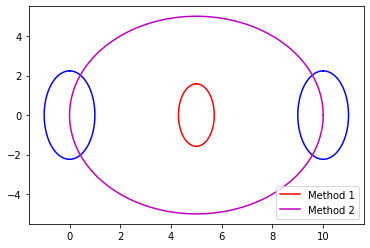

In [7]:
from averagingEllipsesRoutines import averageEllipses_Berkeley, averageEllipses_Davis, plotEllipse, pointInEllipse

mean0 = np.array([0,0]).reshape((2,1))
mean1 = np.array([10,0]).reshape((2,1))

cov0 = np.array([[1,0],[0,5]])
cov1 = np.copy(cov0)

n_sigma = 1

maj0, min0, ang0, x0, y0 = plotEllipse(mean0, cov0, n_sigma)
maj1, min1, ang1, x1, y1 = plotEllipse(mean1, cov1, n_sigma)

plt.plot(x0,y0,'b')
plt.plot(x1,y1,'b')

ellipse_mu = np.vstack((mean0,mean1)).reshape(2,2,1)
ellipse_cov = np.vstack((cov0,cov1)).reshape(2,2,2)

mu_weightedMean_Davis, cov_Davis = averageEllipses_Davis(ellipse_mu, ellipse_cov)
mu_weightedMean_Berkeley, cov_Berkeley = averageEllipses_Berkeley(ellipse_mu, ellipse_cov)

major_Davis, minor_Davis, angle_Davis, xDavis, yDavis = plotEllipse(mu_weightedMean_Davis, cov_Davis, n_sigma)
major_Berkeley, minor_Berkeley, angle_Berkeley, xBerk, yBerk  = plotEllipse(mu_weightedMean_Berkeley, cov_Berkeley, n_sigma)

plt.plot(xDavis,yDavis,'r',label='Method 1')
plt.plot(xBerk,yBerk,'m',label='Method 2')
plt.legend()

So we see that using method 1, we have a smaller variance/standard error of the weighted mean, while for method 2 we have a far larger standard error. So this really is a choice; if one truly believes that the two individual (blue) measurements are accurate and have estimated the variance well, then having a shrinking 'error' is reasonable. But if there is no way to be sure, then method 2 reflects the reality of the separated measurements well; there's no reason to suppose that you can obtain a more accurate estimate or localization from these two estranged measurements. Indeed, since method 1 ignores the measurement centres, the two blue ellipses could have gone to $+/- \infty$ and the resultant size of the method 1 red ellipse would still be the same. On the other hand, method 2 would stretch further and further, reflecting the 'uncertainty' of the centres of the measurements (blue ellipses).

## Averaging Many Ellipses

"But that's only 2 ellipses, as you make more measurements there will be no difference between the 2!" you say. Not quite, though. Let's consider a bunch of measurements with their centres normally distributed, and their covariances also normally distributed. We'll also allow the ellipses to be rotated i.e. non-diagonal covariances. We'll change the normal distributions for each of these and see how things go.

0.030530432520447636
0.012023053451755524


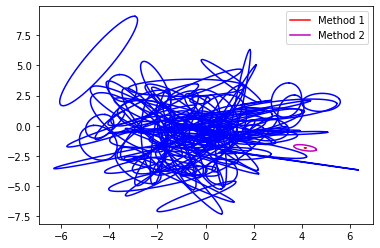

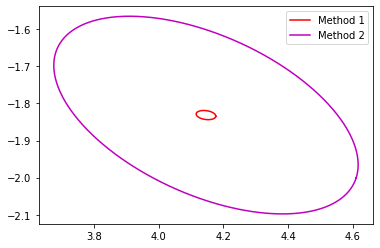

In [8]:
# Ground truth
ref_mu = np.array([[0],[0]])

# Simulation ellipses parameters
num_ellipse = 100
mu_sigma = 2

major_mean = 2
major_sigma = 1
minor_mean = 0.5
minor_sigma = 0.25

ellipse_x = np.random.normal(ref_mu[0], mu_sigma, num_ellipse)
ellipse_y = np.random.normal(ref_mu[1], mu_sigma, num_ellipse)
ellipse_xy = np.vstack((ellipse_x,ellipse_y)).T.reshape(num_ellipse,2,1)
ellipse_mu = ellipse_xy.reshape(num_ellipse,2,1)

ellipse_major = np.random.normal(major_mean, major_sigma, num_ellipse).reshape(num_ellipse,1)
ellipse_minor = np.random.normal(minor_mean, minor_sigma, num_ellipse).reshape(num_ellipse,1)
ellipse_angle = (np.random.rand(num_ellipse,1)-0.5)*2*np.pi # angle sample from uniform distribution

# Compute covariance matrices for generated ellipses

ellipse_cov = np.zeros((num_ellipse,2,2))

for n in np.arange(num_ellipse):

    ellipse_diag = np.array([[ellipse_major[n,0]**2, 0], [0, ellipse_minor[n,0]**2]])
    ellipse_rot = np.array([[np.cos(ellipse_angle[n,0]), -np.sin(ellipse_angle[n,0])], [np.sin(ellipse_angle[n,0]), np.cos(ellipse_angle[n,0])]]) # ellipse rotation matrix 
    ellipse_cov[n,:,:] = ellipse_rot@ellipse_diag@(ellipse_rot.T)
    
    maj0, min0, ang0, x0, y0 = plotEllipse(ellipse_mu[n], ellipse_cov[n], n_sigma)
    plt.plot(x0,y0,'b')
    
mu_weightedMean_Davis, cov_Davis = averageEllipses_Davis(ellipse_mu, ellipse_cov)
mu_weightedMean_Berkeley, cov_Berkeley = averageEllipses_Berkeley(ellipse_mu, ellipse_cov)

major_Davis, minor_Davis, angle_Davis, xDavis, yDavis = plotEllipse(mu_weightedMean_Davis, cov_Davis, n_sigma)
major_Berkeley, minor_Berkeley, angle_Berkeley, xBerk, yBerk  = plotEllipse(mu_weightedMean_Berkeley, cov_Berkeley, n_sigma)

plt.plot(xDavis,yDavis,'r',label='Method 1')
plt.plot(xBerk,yBerk,'m',label='Method 2')
plt.legend()

plt.figure()
plt.plot(xDavis,yDavis,'r',label='Method 1')
plt.plot(xBerk,yBerk,'m',label='Method 2')
plt.legend()

print(major_Davis)
print(minor_Davis)

Alright, so method 1 is still smaller than method 2. But remember, this is because method 2 is reflective of the **centres** of each measurement; since the measurements we simulated are all over the place, and not anywhere clustered near $(0,0)$, the method 2 ellipse reflects this spread by being larger. It is, notably, still much smaller than the spread of the original measurements, as is expected of a smaller uncertainty due to averaging! But now let's decrease the spread of the measurements without touching their covariances.

0.030530432520447636
0.012023053451755524


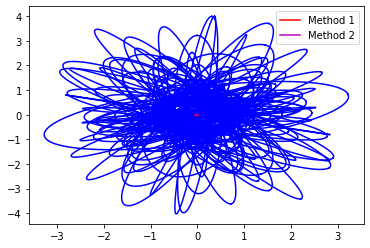

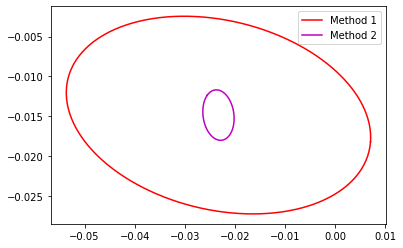

In [9]:
mu_sigma = 0.02

ellipse_x = np.random.normal(ref_mu[0], mu_sigma, num_ellipse)
ellipse_y = np.random.normal(ref_mu[1], mu_sigma, num_ellipse)
ellipse_xy = np.vstack((ellipse_x,ellipse_y)).T.reshape(num_ellipse,2,1)
ellipse_mu = ellipse_xy.reshape(num_ellipse,2,1)

for n in np.arange(num_ellipse):
    maj0, min0, ang0, x0, y0 = plotEllipse(ellipse_mu[n], ellipse_cov[n], n_sigma)
    plt.plot(x0,y0,'b')
    
mu_weightedMean_Davis, cov_Davis = averageEllipses_Davis(ellipse_mu, ellipse_cov)
mu_weightedMean_Berkeley, cov_Berkeley = averageEllipses_Berkeley(ellipse_mu, ellipse_cov)

major_Davis, minor_Davis, angle_Davis, xDavis, yDavis = plotEllipse(mu_weightedMean_Davis, cov_Davis, n_sigma)
major_Berkeley, minor_Berkeley, angle_Berkeley, xBerk, yBerk  = plotEllipse(mu_weightedMean_Berkeley, cov_Berkeley, n_sigma)

plt.plot(xDavis,yDavis,'r',label='Method 1')
plt.plot(xBerk,yBerk,'m',label='Method 2')
plt.legend()

plt.figure()
plt.plot(xDavis,yDavis,'r',label='Method 1')
plt.plot(xBerk,yBerk,'m',label='Method 2')
plt.legend()

print(major_Davis)
print(minor_Davis)

So by making our measurements cluster together, we see that method 1's ellipse is actually larger than method 2's. Again, this is reflective of our measurement centres; since they are so tightly clustered, method 2's final ellipse shrinks to indicate the 'goodness of clustering'. Method 1 doesn't care; it just sees that the covariances for each measurement didn't change, so the eventual variance is identical (see the printed major and minor values for the previous scenario compared to this).

## Respecting the Probability

Another way to look at this is to consider the scenario where one would like to treat the final ellipse as a confidence indicator; that is, drawing the final ellipse should (assuming it is 1 $\sigma$ in both axes) entail that the true position is within the ellipse around 39% of the time, as demonstrated by the primer at the start. The factors which determine which method better fits this stipulated criterion include all of the above-used variables in the simulation: the clustering of the centres, the sizes of the original ellipses. Obviously, the larger the original measurement ellipses, the larger the eventual final ellipse, and the more likely the true point lies within it. On the other hand, with better clustering, method 2 may - correctly or incorrectly - become smaller, and as such the true point would not lie in the eventual method 2 ellipse.